In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/amazon-fine-food-reviews


## SENTIMENT ANALYSIS IN PYTHON

In this notebook we will be doing some sentiment analysis in python usig two different technique:

1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from 🤗
3. Huggingface Pipeline


Step 0. Read in data and NLTK Basics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [3]:
# Read in data

df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(568454, 10)
(500, 10)


In [4]:
df.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

## Quick EDA

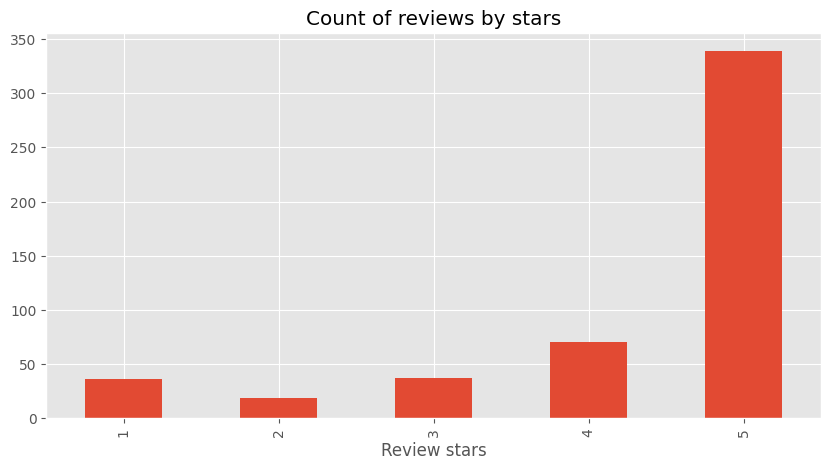

In [5]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar' ,
          title = 'Count of reviews by stars',
          figsize =(10,5))

ax.set_xlabel('Review stars')
plt.show()

## Basic NLTK

In [6]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [7]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']


## Step 1. VADER Seniment Scoring

We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

    This uses a "bag of words" approach:
        Stop words are removed
        each word is scored and combined to a total score.



In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [9]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [10]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [11]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [12]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [13]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [14]:
# Now we have sentiment score and metadata
vaders.head()

Id    neg    neu    pos  compound   ProductId          UserId  \
0   1  0.000  0.695  0.305    0.9441  B001E4KFG0  A3SGXH7AUHU8GW   
1   2  0.138  0.862  0.000   -0.5664  B00813GRG4  A1D87F6ZCVE5NK   
2   3  0.091  0.754  0.155    0.8265  B000LQOCH0   ABXLMWJIXXAIN   
3   4  0.000  1.000  0.000    0.0000  B000UA0QIQ  A395BORC6FGVXV   
4   5  0.000  0.552  0.448    0.9468  B006K2ZZ7K  A1UQRSCLF8GW1T   

                       ProfileName  HelpfulnessNumerator  \
0                       delmartian                     1   
1                           dll pa                     0   
2  Natalia Corres "Natalia Corres"                     1   
3                             Karl                     3   
4    Michael D. Bigham "M. Wassir"                     0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      5  1303862400  Good Quality Dog Food   
1                       0      1  1346976000      Not as Advertised   
2                       1      4  1219017600  "Delight" says it all   
3                       3      2  1307923200         Cough Medicine   
4                       0      5  1350777600            Great taffy   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
2  This is a confection that has been around a fe...  
3  If you are looking for the secret ingredient i...  
4  Great taffy at a great price.  There was a wid...


## Plot VADER results

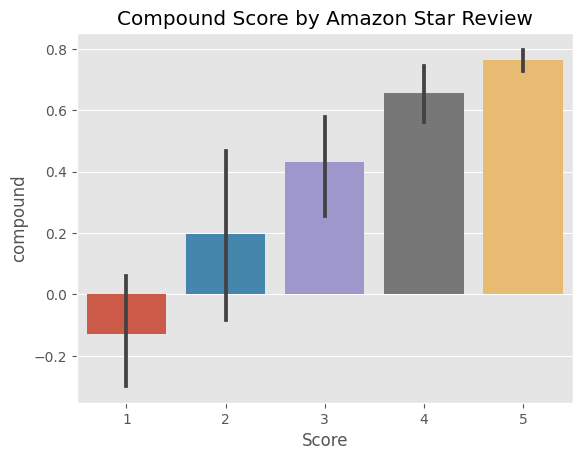

In [15]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound Score by Amazon Star Review')
plt.show()



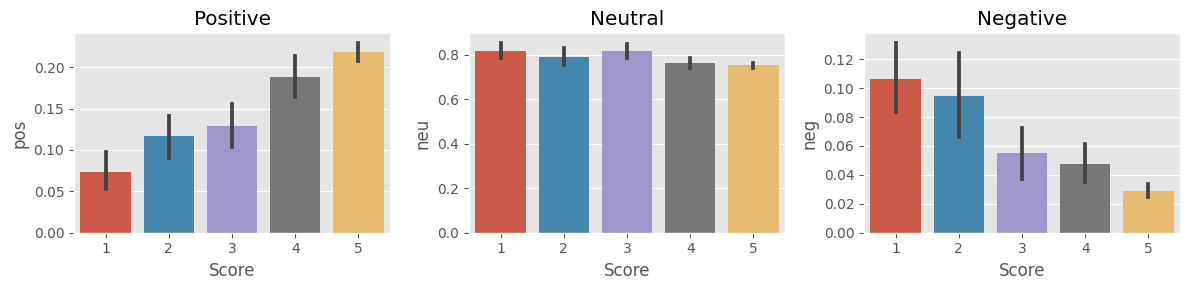

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

## Step 3. Roberta Pretrained Model

    Use a model trained of a large corpus of data.
    Transformer model accounts for the words but also the context related to oth

In [17]:

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax


In [18]:

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

2025-06-28 20:23:42.624851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751142223.096528      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751142223.220003      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [19]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [20]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687463, 'roberta_pos': 0.002957368}


In [21]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [22]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [23]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

## Compare Scores between models

In [24]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

## Step 3 Combine and compare

In [25]:
results_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [26]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


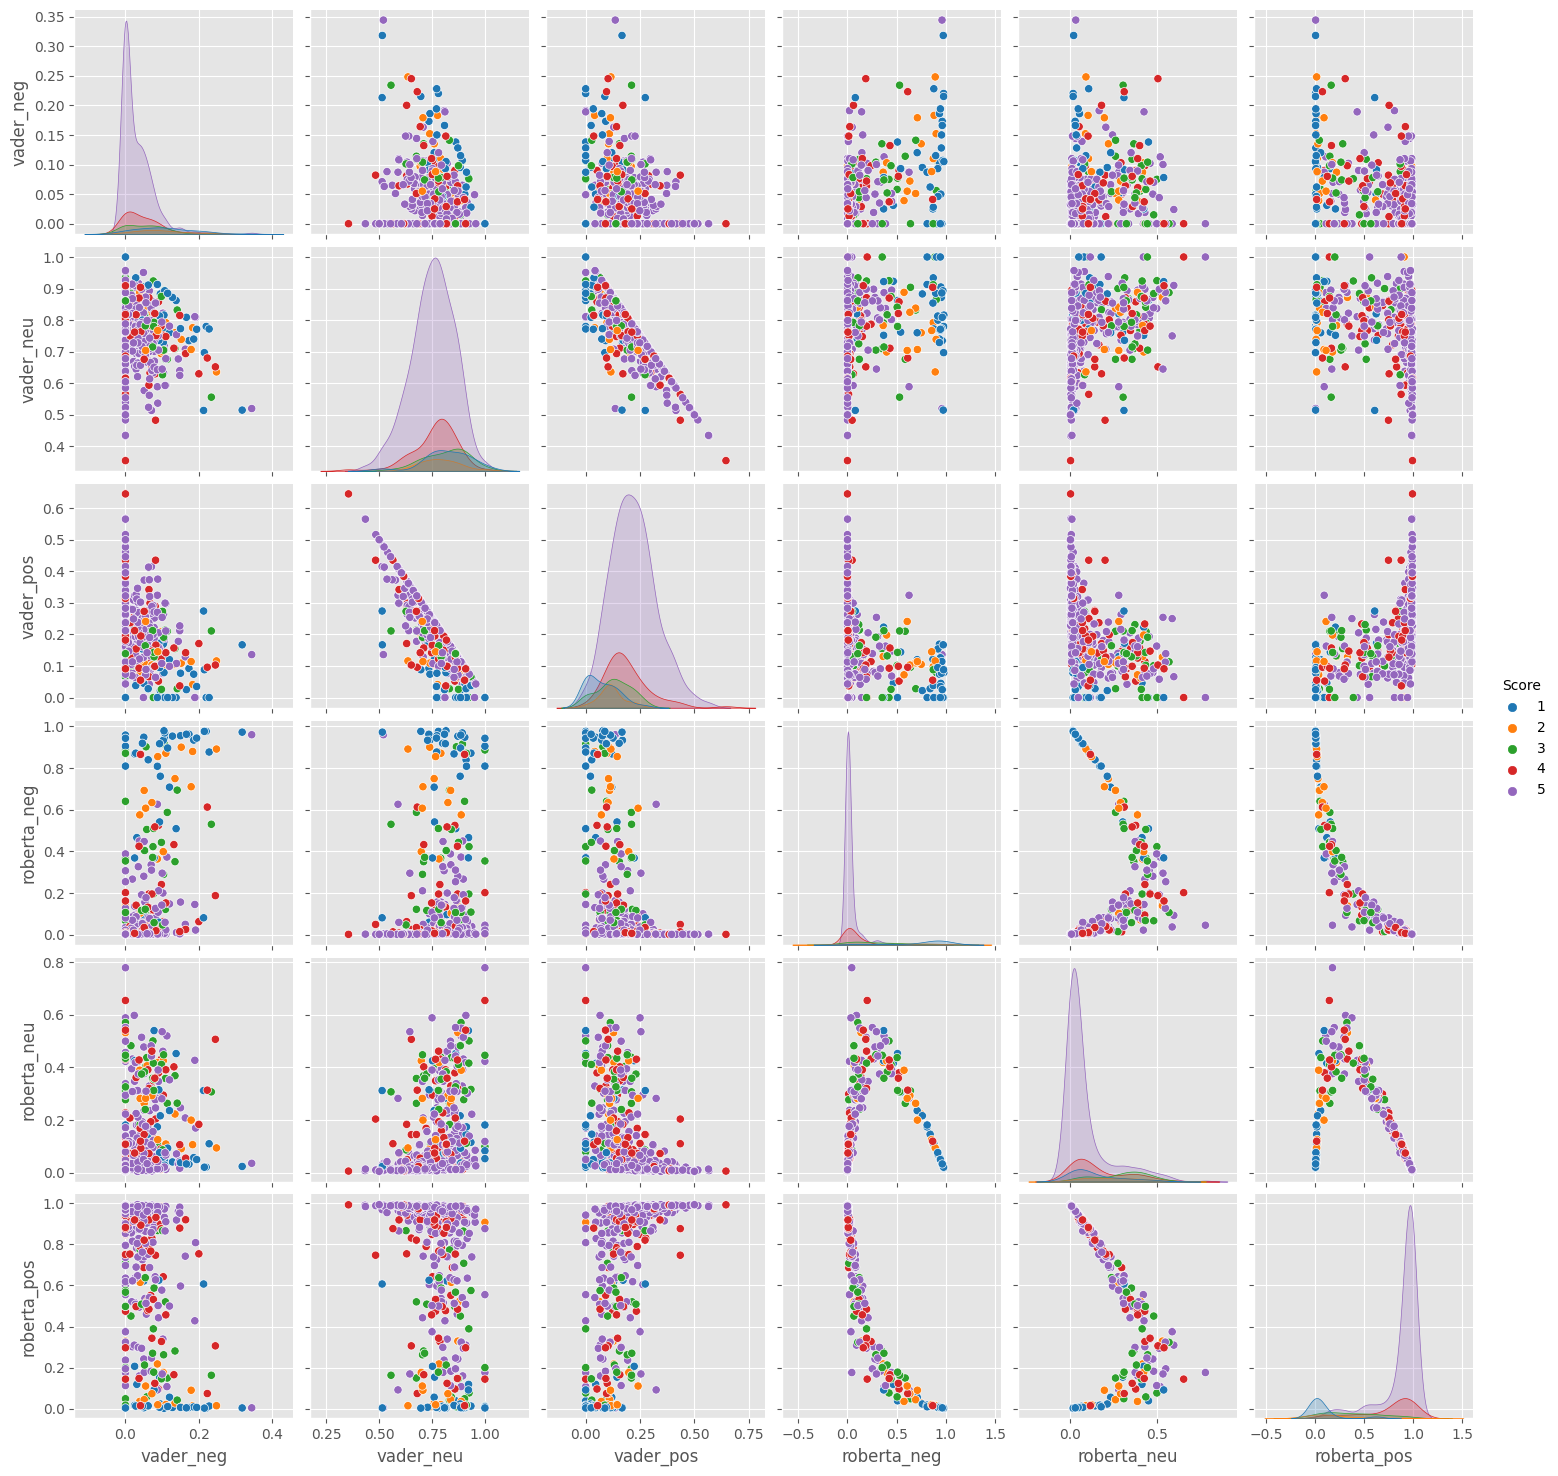

In [27]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()


## Step 4 Review Examples


*  Positive 1-Star and Negative 5-Star Reviews
  Lets look at some examples where the model scoring and review score differ the most

In [28]:
results_df.query('Score==1')\
     .sort_values('roberta_pos', ascending=False)['Text'].values[0]


'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [29]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [30]:
# negative sentiment 5 star review

In [31]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [32]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

# Step 5 Extra: The transformers pipeline
* Quick and easy way to run sentiment predictions

In [33]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


True
2
Tesla T4


In [34]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [35]:
sent_pipeline('I loved doing this sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9994736313819885}]

In [36]:
sent_pipeline('please do like and subscribe')

[{'label': 'POSITIVE', 'score': 0.9948636889457703}]

In [37]:
sent_pipeline('very bad reviews')

[{'label': 'NEGATIVE', 'score': 0.9997826218605042}]

In [38]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

In [39]:
sent_pipeline('I love my self ')

[{'label': 'POSITIVE', 'score': 0.999848484992981}]

In [40]:
sent_pipeline('this is the worst thing i have ever seen')

[{'label': 'NEGATIVE', 'score': 0.9997521042823792}]